In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import numpy as np
import thinkplot
import thinkstats2
import seaborn as sns
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf

In [2]:
# import tax income data
#data_link = pd.read_excel("https://www.irs.gov/pub/irs-soi/17zp34nc.xlsx", skip_rows = 3)
data = pd.read_excel("NC_Tax_Return2017.xlsx", header = None, skiprows = 14, skipfooter = 18)
data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,150
0,27006.0,NaN,6900.0,2610.0,3650.0,490.0,6180.0,400.0,3890.0,3460.0,...,390.0,1153.0,1970.0,14485.0,4690.0,15475.0,4470.0,12892.0,330.0,2580.0
1,27006.0,"$1 under $25,000",1900.0,1410.0,280.0,170.0,1640.0,130.0,880.0,1030.0,...,0.0,0.0,230.0,194.0,1470.0,2087.0,1460.0,2078.0,0.0,0.0
2,27006.0,"$25,000 under $50,000",1220.0,580.0,420.0,160.0,1080.0,60.0,670.0,750.0,...,0.0,0.0,230.0,330.0,960.0,2316.0,940.0,2222.0,50.0,99.0
3,27006.0,"$50,000 under $75,000",930.0,320.0,510.0,70.0,840.0,50.0,540.0,480.0,...,0.0,0.0,290.0,658.0,630.0,1716.0,600.0,1649.0,40.0,67.0
4,27006.0,"$75,000 under $100,000",760.0,130.0,580.0,40.0,700.0,40.0,450.0,390.0,...,0.0,0.0,250.0,672.0,510.0,1609.0,480.0,1497.0,50.0,112.0
5,27006.0,"$100,000 under $200,000",1430.0,120.0,1260.0,50.0,1310.0,80.0,850.0,630.0,...,0.0,0.0,620.0,2819.0,810.0,3394.0,750.0,3031.0,90.0,364.0
6,27006.0,"$200,000 or more",660.0,50.0,600.0,0.0,610.0,40.0,500.0,180.0,...,390.0,1153.0,350.0,9812.0,310.0,4353.0,240.0,2415.0,100.0,1938.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,27007.0,NaN,900.0,320.0,500.0,90.0,820.0,60.0,580.0,550.0,...,0.0,0.0,150.0,399.0,710.0,1943.0,710.0,1917.0,0.0,0.0
9,27007.0,"$1 under $25,000",350.0,200.0,100.0,50.0,320.0,40.0,210.0,200.0,...,0.0,0.0,30.0,29.0,290.0,607.0,290.0,606.0,0.0,0.0


In [3]:
# import city/state data to idenitfy what city each zip code belongs to
zip_data = pd.read_csv("zip_code_state.csv", sep = ';')
zip_data['Zip'] = zip_data['Zip'].astype('int')
zip_data['Zip'] = zip_data['Zip'].astype('str')
zip_data

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,71937,Cove,AR,34.398483,-94.393980,-6,1,"34.398483,-94.39398"
1,72044,Edgemont,AR,35.624351,-92.160560,-6,1,"35.624351,-92.16056"
2,56171,Sherburn,MN,43.660847,-94.743570,-6,1,"43.660847,-94.74357"
3,49430,Lamont,MI,43.010337,-85.897540,-5,1,"43.010337,-85.89754"
4,52585,Richland,IA,41.194129,-91.980270,-6,1,"41.194129,-91.98027"
...,...,...,...,...,...,...,...,...
43186,15207,Pittsburgh,PA,40.399355,-79.934140,-5,1,"40.399355,-79.93414"
43187,52647,Olds,IA,41.133346,-91.545590,-6,1,"41.133346,-91.54559"
43188,16683,Spruce Creek,PA,40.662087,-78.070120,-5,1,"40.662087,-78.07012"
43189,55459,Minneapolis,MN,45.015914,-93.471880,-6,1,"45.015914,-93.47188"


In [4]:
# create a df of only the select variables needed for this test
df = data[[0,1,2,12,39,58,111]]
df.columns = ['zip_code', 'income', 'returns', 'volunteer_returns','farm_returns','active_student_returns','dependent_returns']
df = df.dropna(subset=['zip_code'])
df = df.dropna(subset=['income'])
df['percent_volunteer'] = round(df['volunteer_returns'] / df['returns']*100,2)
income = df.income.str.split("under",expand=True)
df['income'] = income[1].to_list()
df['income'].loc[(df['income'].isna())] = 'Greater than 200,000'
df['zip_code'] = df['zip_code'].astype('int')
df['zip_code'] = df['zip_code'].astype('str')
# Review for any NA values. Only NA is percent volunteer which is ok because if there are no volunteer returns, it 
# will be NA
df.isna().sum()

/Users/kenny/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


zip_code                    0
income                      0
returns                     0
volunteer_returns           0
farm_returns                0
active_student_returns      0
dependent_returns           0
percent_volunteer         281
dtype: int64

In [5]:
# Create a df that combined the tax data with the zip code data to identify city cames and geolocation
merged_data = df.merge(zip_data, left_on='zip_code', right_on='Zip')

Text(0.5, 1.0, 'Total Parent Returns')

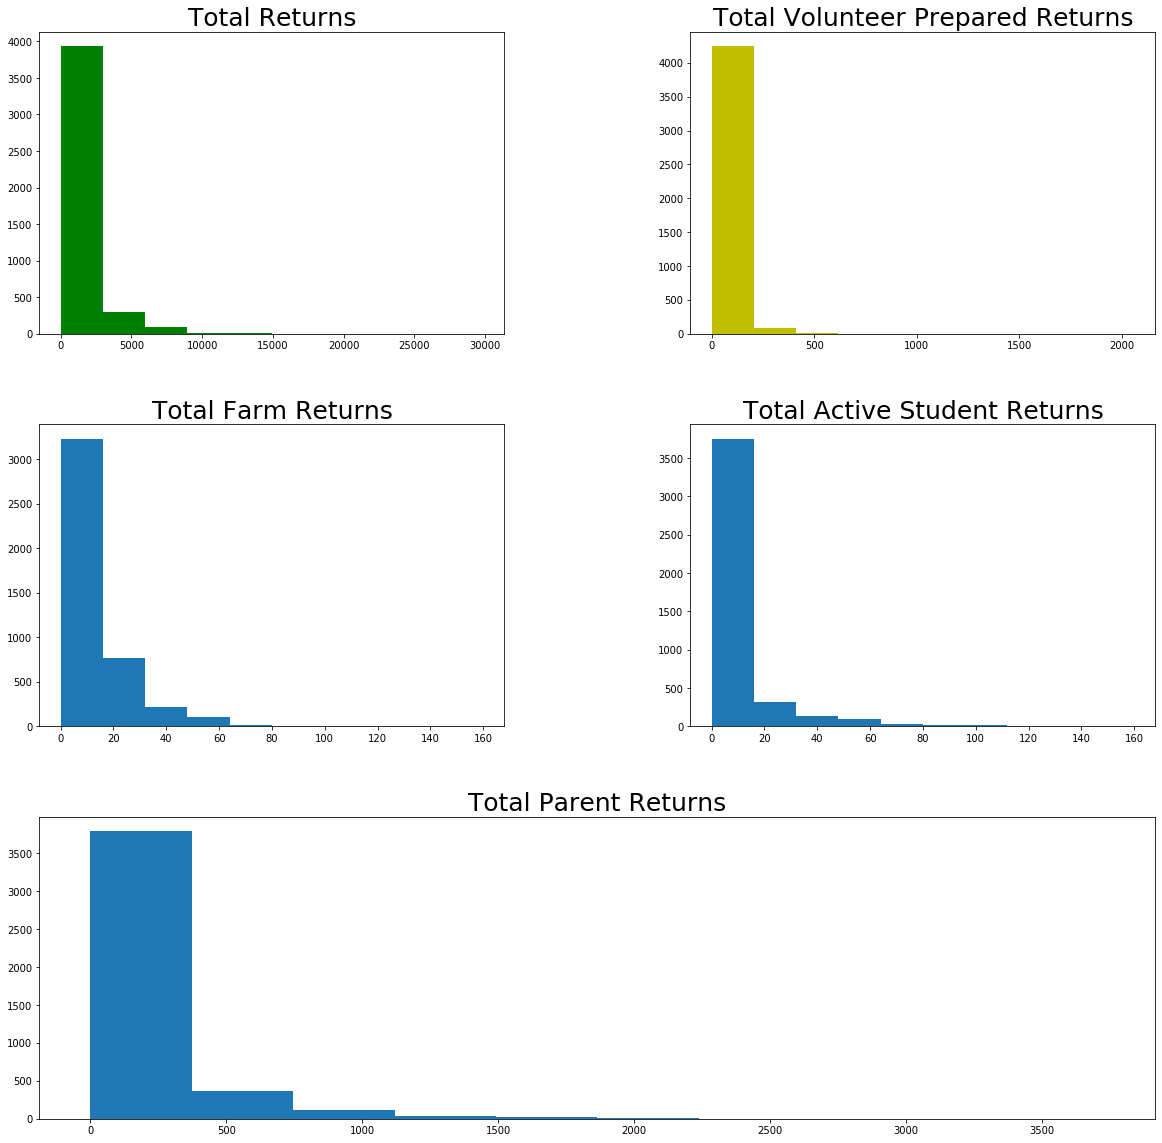

In [6]:
# Histograms for all 5 variables
fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3, 2, wspace=0.4, hspace=0.3)
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[0, 1])
ax3 = fig.add_subplot(grid[1, 0])
ax4 = fig.add_subplot(grid[1, 1])
ax5 = fig.add_subplot(grid[2, :2])
ax1.hist(df['returns'], color = 'g')
ax1.set_title('Total Returns', fontsize = 25)
ax2.hist(df['volunteer_returns'], color = 'y')
ax2.set_title('Total Volunteer Prepared Returns', fontsize = 25)
ax3.hist(df['farm_returns'])
ax3.set_title('Total Farm Returns', fontsize = 25)
ax4.hist(df['active_student_returns'])
ax4.set_title('Total Active Student Returns', fontsize = 25)
ax5.hist(df['dependent_returns'])
ax5.set_title('Total Parent Returns', fontsize = 25)

In [7]:
# Outlier analysis for returns. Look at top 15 returns a make sure no outliers.
merged_data.sort_values(by=['returns'], ascending = False).head(15)

,zip_code,income,returns,volunteer_returns,farm_returns,active_student_returns,dependent_returns,percent_volunteer,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
1110,27610,"$25,000",14260.0,370.0,20.0,70.0,690.0,2.59,27610,Raleigh,NC,35.767829,-78.58610,-5,1,"35.767829,-78.5861"
2454,28269,"$25,000",13070.0,370.0,0.0,90.0,480.0,2.83,28269,Charlotte,NC,35.329235,-80.80486,-5,1,"35.329235,-80.80486"
672,27406,"$25,000",12420.0,440.0,20.0,50.0,510.0,3.54,27406,Greensboro,NC,36.022863,-79.77895,-5,1,"36.022863,-79.77895"
2418,28215,"$25,000",12050.0,330.0,0.0,60.0,590.0,2.74,28215,Charlotte,NC,35.244468,-80.72164,-5,1,"35.244468,-80.72164"
1344,27834,"$25,000",11190.0,210.0,0.0,90.0,550.0,1.88,27834,Greenville,NC,35.626653,-77.37896,-5,1,"35.626653,-77.37896"
2424,28216,"$25,000",11090.0,380.0,0.0,50.0,460.0,3.43,28216,Charlotte,NC,35.286967,-80.87903,-5,1,"35.286967,-80.87903"
666,27405,"$25,000",10920.0,370.0,0.0,60.0,490.0,3.39,27405,Greensboro,NC,36.107499,-79.75242,-5,1,"36.107499,-79.75242"
2526,28314,"$25,000",10740.0,440.0,20.0,50.0,440.0,4.10,28314,Fayetteville,NC,35.060087,-79.00848,-5,1,"35.060087,-79.00848"
2442,28227,"$25,000",10290.0,220.0,0.0,60.0,360.0,2.14,28227,Charlotte,NC,35.192919,-80.66822,-5,1,"35.192919,-80.66822"
1950,28027,"$25,000",10270.0,200.0,0.0,60.0,330.0,1.95,28027,Concord,NC,35.405636,-80.63823,-5,1,"35.405636,-80.63823"


In [8]:
# Review cities and income brackets for for zero returns
zero_returns = merged_data[merged_data['returns']==0]
zero_returns['City'].value_counts()

Cedar Island    3
Edward          3
Kelford         3
Sealevel        3
Vandemere       3
               ..
Hot Springs     1
Candor          1
Cove City       1
Hiddenite       1
Morven          1
Name: City, Length: 245, dtype: int64

In [9]:
zero_returns['income'].value_counts()

Greater than 200,000    245
 $200,000                21
 $100,000                12
 $75,000                  3
Name: income, dtype: int64

In [10]:
# Outlier analysis for volunteer returns. Look at top 20 returns a make sure no outliers.
merged_data.sort_values(by=['volunteer_returns'], ascending = False).head(20)

,zip_code,income,returns,volunteer_returns,farm_returns,active_student_returns,dependent_returns,percent_volunteer,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
216,27105,"$25,000",9500.0,760.0,20.0,30.0,470.0,8.00,27105,Winston Salem,NC,36.147887,-80.23423,-5,1,"36.147887,-80.23423"
228,27107,"$25,000",8950.0,490.0,40.0,40.0,410.0,5.47,27107,Winston Salem,NC,36.046215,-80.18998,-5,1,"36.046215,-80.18998"
4248,28792,"$25,000",5810.0,480.0,30.0,40.0,220.0,8.26,28792,Hendersonville,NC,35.353837,-82.41625,-5,1,"35.353837,-82.41625"
2527,28314,"$50,000",8070.0,470.0,0.0,30.0,2170.0,5.82,28314,Fayetteville,NC,35.060087,-79.00848,-5,1,"35.060087,-79.00848"
3337,28546,"$50,000",6140.0,470.0,0.0,30.0,1680.0,7.65,28546,Jacksonville,NC,34.781212,-77.37560,-5,1,"34.781212,-77.3756"
618,27360,"$25,000",8280.0,440.0,0.0,20.0,340.0,5.31,27360,Thomasville,NC,35.871000,-80.08603,-5,1,"35.871,-80.08603"
2526,28314,"$25,000",10740.0,440.0,20.0,50.0,440.0,4.10,28314,Fayetteville,NC,35.060087,-79.00848,-5,1,"35.060087,-79.00848"
672,27406,"$25,000",12420.0,440.0,20.0,50.0,510.0,3.54,27406,Greensboro,NC,36.022863,-79.77895,-5,1,"36.022863,-79.77895"
2850,28401,"$25,000",5170.0,410.0,0.0,50.0,210.0,7.93,28401,Wilmington,NC,34.235219,-77.94134,-5,1,"34.235219,-77.94134"
3336,28546,"$25,000",8300.0,400.0,0.0,40.0,320.0,4.82,28546,Jacksonville,NC,34.781212,-77.37560,-5,1,"34.781212,-77.3756"


In [11]:
# Review cities and income brackets for for zero volunteer returns
zero_vol_returns = merged_data[merged_data['volunteer_returns']==0]
zero_vol_returns['City'].value_counts()

Charlotte        87
Raleigh          54
Greensboro       32
Durham           22
Winston Salem    21
                 ..
Hope Mills        1
Raeford           1
Cameron           1
Hubert            1
Fort Bragg        1
Name: City, Length: 609, dtype: int64

In [12]:
zero_vol_returns['income'].value_counts()

Greater than 200,000    720
 $200,000               698
 $100,000               673
 $75,000                543
 $50,000                405
 $25,000                255
Name: income, dtype: int64

In [13]:
# Outlier analysis for farm returns. Look at top 15 returns a make sure no outliers.
merged_data.sort_values(by=['farm_returns'], ascending = False).head(20)

,zip_code,income,returns,volunteer_returns,farm_returns,active_student_returns,dependent_returns,percent_volunteer,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
4098,28753,"$25,000",1980.0,20.0,130.0,0.0,40.0,1.01,28753,Marshall,NC,35.852912,-82.684470,-5,1,"35.852912,-82.68447"
4099,28753,"$50,000",1330.0,0.0,100.0,0.0,290.0,0.00,28753,Marshall,NC,35.852912,-82.684470,-5,1,"35.852912,-82.68447"
2572,28328,"$200,000",660.0,0.0,90.0,0.0,150.0,0.00,28328,Clinton,NC,35.000056,-78.334240,-5,1,"35.000056,-78.33424"
3594,28625,"$25,000",6230.0,180.0,90.0,20.0,230.0,2.89,28625,Statesville,NC,35.840579,-80.879880,-5,1,"35.840579,-80.87988"
4080,28748,"$25,000",2230.0,80.0,80.0,0.0,70.0,3.59,28748,Leicester,NC,35.661009,-82.735130,-5,1,"35.661009,-82.73513"
102,27028,"$25,000",4450.0,120.0,80.0,20.0,150.0,2.70,27028,Mocksville,NC,35.920477,-80.571430,-5,1,"35.920477,-80.57143"
576,27344,"$25,000",3240.0,80.0,70.0,0.0,200.0,2.47,27344,Siler City,NC,35.729692,-79.449840,-5,1,"35.729692,-79.44984"
3930,28714,"$25,000",2610.0,0.0,70.0,0.0,60.0,0.00,28714,Burnsville,NC,35.891276,-82.300080,-5,1,"35.891276,-82.30008"
103,27028,"$50,000",3130.0,50.0,70.0,0.0,770.0,1.60,27028,Mocksville,NC,35.920477,-80.571430,-5,1,"35.920477,-80.57143"
104,27028,"$75,000",1690.0,0.0,70.0,0.0,520.0,0.00,27028,Mocksville,NC,35.920477,-80.571430,-5,1,"35.920477,-80.57143"


In [14]:
# Outlier analysis for student returns. Look at top 15 returns a make sure no outliers.
merged_data.sort_values(by=['active_student_returns'], ascending = False).head(20)

,zip_code,income,returns,volunteer_returns,farm_returns,active_student_returns,dependent_returns,percent_volunteer,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
1086,27606,"$25,000",7880.0,140.0,0.0,160.0,180.0,1.78,27606,Raleigh,NC,35.758268,-78.717830,-5,1,"35.758268,-78.71783"
1170,27705,"$25,000",6570.0,230.0,0.0,150.0,210.0,3.50,27705,Durham,NC,36.015992,-78.959110,-5,1,"36.015992,-78.95911"
1030,27587,"$200,000",7190.0,0.0,50.0,130.0,1770.0,0.00,27587,Wake Forest,NC,35.971540,-78.522410,-5,1,"35.97154,-78.52241"
1176,27707,"$25,000",8360.0,320.0,0.0,130.0,350.0,3.83,27707,Durham,NC,35.963994,-78.936020,-5,1,"35.963994,-78.93602"
2044,28078,"$200,000",7130.0,0.0,40.0,130.0,1680.0,0.00,28078,Huntersville,NC,35.409544,-80.863620,-5,1,"35.409544,-80.86362"
718,27502,"$200,000",5260.0,0.0,30.0,130.0,1510.0,0.00,27502,Apex,NC,35.736630,-78.864620,-5,1,"35.73663,-78.86462"
774,27514,"$25,000",3330.0,120.0,0.0,120.0,60.0,3.60,27514,Chapel Hill,NC,35.915083,-79.029390,-5,1,"35.915083,-79.02939"
802,27519,"$200,000",7370.0,20.0,40.0,120.0,1920.0,0.27,27519,Cary,NC,35.768120,-78.829548,-5,1,"35.76812,-78.829548"
2476,28277,"$200,000",7580.0,0.0,0.0,110.0,1610.0,0.00,28277,Charlotte,NC,35.054546,-80.817920,-5,1,"35.054546,-80.81792"
772,27513,"$200,000",4930.0,0.0,0.0,110.0,910.0,0.00,27513,Cary,NC,35.797882,-78.797020,-5,1,"35.797882,-78.79702"


In [15]:
# Outlier analysis for parent returns. Look at top 15 returns a make sure no outliers.
merged_data.sort_values(by=['dependent_returns'], ascending = False).head(20)

,zip_code,income,returns,volunteer_returns,farm_returns,active_student_returns,dependent_returns,percent_volunteer,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
1111,27610,"$50,000",9770.0,220.0,0.0,50.0,2980.0,2.25,27610,Raleigh,NC,35.767829,-78.586100,-5,1,"35.767829,-78.5861"
2455,28269,"$50,000",10160.0,260.0,0.0,50.0,2600.0,2.56,28269,Charlotte,NC,35.329235,-80.804860,-5,1,"35.329235,-80.80486"
2419,28215,"$50,000",7880.0,180.0,0.0,30.0,2230.0,2.28,28215,Charlotte,NC,35.244468,-80.721640,-5,1,"35.244468,-80.72164"
2527,28314,"$50,000",8070.0,470.0,0.0,30.0,2170.0,5.82,28314,Fayetteville,NC,35.060087,-79.008480,-5,1,"35.060087,-79.00848"
2425,28216,"$50,000",8170.0,280.0,0.0,30.0,2050.0,3.43,28216,Charlotte,NC,35.286967,-80.879030,-5,1,"35.286967,-80.87903"
802,27519,"$200,000",7370.0,20.0,40.0,120.0,1920.0,0.27,27519,Cary,NC,35.768120,-78.829548,-5,1,"35.76812,-78.829548"
673,27406,"$50,000",7550.0,220.0,0.0,30.0,1910.0,2.91,27406,Greensboro,NC,36.022863,-79.778950,-5,1,"36.022863,-79.77895"
1159,27703,"$50,000",7230.0,150.0,0.0,30.0,1880.0,2.07,27703,Durham,NC,35.966431,-78.839690,-5,1,"35.966431,-78.83969"
1951,28027,"$50,000",7460.0,110.0,50.0,30.0,1820.0,1.47,28027,Concord,NC,35.405636,-80.638230,-5,1,"35.405636,-80.63823"
667,27405,"$50,000",6100.0,190.0,0.0,0.0,1820.0,3.11,27405,Greensboro,NC,36.107499,-79.752420,-5,1,"36.107499,-79.75242"


In [16]:
# generate descriptive characteristics for all variables
total_return_name = 'total returns variable'
total_returns_mean = round(df['returns'].mean(),2)
total_returns_mode = round(statistics.mode(df['returns']),2)
total_returns_spread = round(df['returns'].var(),2)
total_returns_q3 =  np.quantile(df['returns'], .75)
total_returns_q1 =  np.quantile(df['returns'], .25)
print('The mean of the {} is {}\nThe mode of the {} is {}\nThe spread of the {} is {}\nThe Q3 and Q1 tails of {} is {} and {}'
      .format(total_return_name,total_returns_mean,total_return_name,total_returns_mode,total_return_name,
              total_returns_spread,total_return_name,total_returns_q3,total_returns_q1,))

The mean of the total returns variable is 1041.04
The mode of the total returns variable is 0.0
The spread of the total returns variable is 2806884.16
The Q3 and Q1 tails of total returns variable is 1260.0 and 110.0


In [17]:
total_vol_return_name = 'total volunteer returns variable'
total_vol_returns_mean = round(df['volunteer_returns'].mean(),2)
total_vol_returns_mode = round(statistics.mode(df['volunteer_returns']),2)
total_vol_returns_spread = round(df['volunteer_returns'].var(),2)
total_vol_returns_q3 =  np.quantile(df['volunteer_returns'], .75)
total_vol_returns_q1 =  np.quantile(df['volunteer_returns'], .25)
print('The mean of the {} is {}\nThe mode of the {} is {}\nThe spread of the {} is {}\nThe Q3 and Q1 tails of {} is {} and {}'
      .format(total_vol_return_name,total_vol_returns_mean,total_vol_return_name,total_vol_returns_mode,
              total_vol_return_name,total_vol_returns_spread,total_vol_return_name,total_vol_returns_q3,
              total_vol_returns_q1,))

The mean of the total volunteer returns variable is 21.22
The mode of the total volunteer returns variable is 0.0
The spread of the total volunteer returns variable is 4127.67
The Q3 and Q1 tails of total volunteer returns variable is 0.0 and 0.0


In [18]:
total_farm_return_name = 'total farm returns variable'
total_farm_returns_mean = round(df['farm_returns'].mean(),2)
total_farm_returns_mode = round(statistics.mode(df['farm_returns']),2)
total_farm_returns_spread = round(df['farm_returns'].var(),2)
total_farm_returns_q3 =  np.quantile(df['farm_returns'], .75)
total_farm_returns_q1 =  np.quantile(df['farm_returns'], .25)
print('The mean of the {} is {}\nThe mode of the {} is {}\nThe spread of the {} is {}\nThe Q3 and Q1 tails of {} is {} and {}'
      .format(total_farm_return_name,total_farm_returns_mean,total_farm_return_name,total_farm_returns_mode,
              total_farm_return_name,total_farm_returns_spread,total_farm_return_name,total_farm_returns_q3,
              total_farm_returns_q1,))

The mean of the total farm returns variable is 8.28
The mode of the total farm returns variable is 0.0
The spread of the total farm returns variable is 244.74
The Q3 and Q1 tails of total farm returns variable is 20.0 and 0.0


In [19]:
total_stu_return_name = 'total active student returns variable'
total_stu_returns_mean = round(df['active_student_returns'].mean(),2)
total_stu_returns_mode = round(statistics.mode(df['active_student_returns']),2)
total_stu_returns_spread = round(df['active_student_returns'].var(),2)
total_stu_returns_std = round(df['active_student_returns'].std(),2)
total_stu_returns_q3 =  np.quantile(df['active_student_returns'], .75)
total_stu_returns_q1 =  np.quantile(df['active_student_returns'], .25)
print('The mean of the {} is {}\nThe mode of the {} is {}\nThe spread of the {} is {}\nThe Q3 and Q1 tails of {} is {} and {}'
      .format(total_stu_return_name,total_stu_returns_mean,total_stu_return_name,total_stu_returns_mode,
              total_stu_return_name,total_stu_returns_spread,total_stu_return_name,total_stu_returns_q3,
              total_stu_returns_q1,))

The mean of the total active student returns variable is 5.36
The mode of the total active student returns variable is 0.0
The spread of the total active student returns variable is 244.22
The Q3 and Q1 tails of total active student returns variable is 0.0 and 0.0


In [20]:
total_dep_return_name = 'total parent returns variable'
total_dep_returns_mean = round(df['dependent_returns'].mean(),2)
total_dep_returns_mode = round(statistics.mode(df['dependent_returns']),2)
total_dep_returns_spread = round(df['dependent_returns'].var(),2)
total_dep_returns_std = round(df['dependent_returns'].std(),2)
total_dep_returns_q3 =  np.quantile(df['dependent_returns'], .75)
total_dep_returns_q1 =  np.quantile(df['dependent_returns'], .25)
print('The mean of the {} is {}\nThe mode of the {} is {}\nThe spread of the {} is {}\nThe Q3 and Q1 tails of {} is {} and {}'
      .format(total_dep_return_name,total_dep_returns_mean,total_dep_return_name,total_dep_returns_mode,
              total_dep_return_name,total_dep_returns_spread,total_dep_return_name,total_dep_returns_q3,
              total_dep_returns_q1,))

The mean of the total parent returns variable is 161.97
The mode of the total parent returns variable is 0.0
The spread of the total parent returns variable is 77150.47
The Q3 and Q1 tails of total parent returns variable is 190.0 and 0.0


In [22]:
# create a df of just volunteer returns
df_volunteer = df[df['volunteer_returns'] != 0]
df_volunteer = df_volunteer[df_volunteer['zip_code'] != '99999']
df_volunteer

,zip_code,income,returns,volunteer_returns,farm_returns,active_student_returns,dependent_returns,percent_volunteer
1,27006,"$25,000",1900.0,30.0,50.0,0.0,40.0,1.58
2,27006,"$50,000",1220.0,20.0,0.0,30.0,200.0,1.64
25,27011,"$25,000",890.0,20.0,30.0,0.0,20.0,2.25
26,27011,"$50,000",670.0,20.0,30.0,0.0,140.0,2.99
33,27012,"$25,000",3790.0,100.0,0.0,30.0,70.0,2.64
...,...,...,...,...,...,...,...,...
5729,28806,"$25,000",8580.0,340.0,20.0,60.0,260.0,3.96
5730,28806,"$50,000",6150.0,160.0,0.0,0.0,1210.0,2.60
5731,28806,"$75,000",2670.0,20.0,20.0,30.0,650.0,0.75
5769,28906,"$25,000",3580.0,50.0,30.0,0.0,100.0,1.40


In [23]:
# functions to idenitfy if an income level is above or below 100k
def income_level(row):
    if row['income'] == ' $25,000':
        return 'Under'
    if row['income'] == ' $75,000':
        return 'Under'
    if row['income'] == ' $50,000':
        return 'Under'
    if row['income'] == ' $100,000':
        return 'Over'
    if row['income'] == ' $200,000':
        return 'Over'
    if row['income'] == 'Greater than 200,000':
        return 'Over'
    return 'Other'

# functions to give numerical value to the categorical variable for income goruping
def income_grouping(row):
    if row['income'] == ' $25,000':
        return 1
    if row['income'] == ' $75,000':
        return 2
    if row['income'] == ' $50,000':
        return 3
    if row['income'] == ' $100,000':
        return 4
    if row['income'] == ' $200,000':
        return 5
    if row['income'] == 'Greater than 200,000':
        return 6
    return 'Other'
    

In [24]:
# create the over/under 100k columns for income groupings. Create PMFs on the two groupings
df_volunteer['income_over/under'] = df_volunteer.apply(lambda row: income_level(row), axis=1)
over = df_volunteer[df_volunteer['income_over/under'] == 'Over']
under = df_volunteer[df_volunteer['income_over/under'] == 'Under']
over_pmf = thinkstats2.Pmf(over.volunteer_returns, label='Over 100k')
under_pmf = thinkstats2.Pmf(under.volunteer_returns, label='Under 100k')

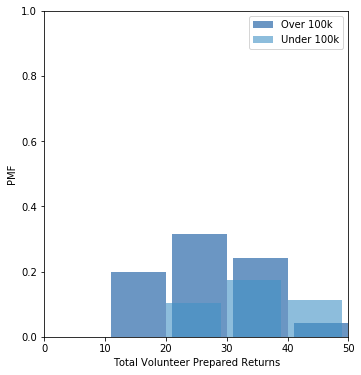

In [27]:
# plot the two PMFs to compare
axis = [0, 50, 0, 1.0]
thinkplot.PrePlot(2, cols=2)
thinkplot.Hist(over_pmf, align='right')
thinkplot.Hist(under_pmf, align='left')
thinkplot.Config(xlabel='Total Volunteer Prepared Returns', ylabel='PMF', axis=axis)

{'xscale': 'linear', 'yscale': 'linear'}

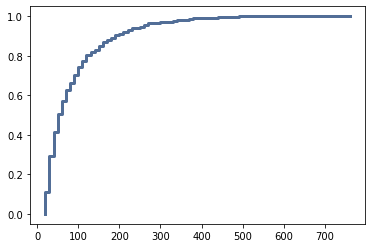

In [28]:
# create a cdf of the volunteer returns and plot it
cdf = thinkstats2.Cdf(df_volunteer.volunteer_returns, label = 'Volunteer Returns')
thinkplot.Cdf(cdf)

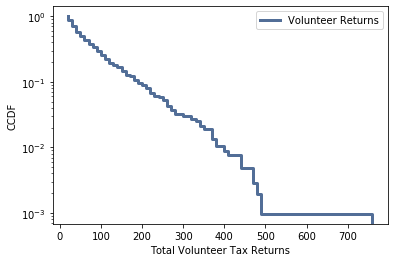

<Figure size 576x432 with 0 Axes>

In [29]:
# create a complementary CDF of the total volunteer returns and plot it

thinkplot.Cdf(cdf, complement = True)
thinkplot.Show(xlabel = 'Total Volunteer Tax Returns', ylabel = 'CCDF', yscale='log')

In [30]:
# run the income groping function to give a numerical value to the corresponding income grouping 
df['income_grouping'] = df.apply(lambda row: income_grouping(row), axis=1)
df

,zip_code,income,returns,volunteer_returns,farm_returns,active_student_returns,dependent_returns,percent_volunteer,income_grouping
1,27006,"$25,000",1900.0,30.0,50.0,0.0,40.0,1.58,1
2,27006,"$50,000",1220.0,20.0,0.0,30.0,200.0,1.64,3
3,27006,"$75,000",930.0,0.0,20.0,0.0,200.0,0.00,2
4,27006,"$100,000",760.0,0.0,0.0,0.0,220.0,0.00,4
5,27006,"$200,000",1430.0,0.0,30.0,0.0,250.0,0.00,5
...,...,...,...,...,...,...,...,...,...
5786,99999,"$50,000",20890.0,980.0,130.0,20.0,3730.0,4.69,3
5787,99999,"$75,000",9190.0,180.0,100.0,0.0,1510.0,1.96,2
5788,99999,"$100,000",4880.0,60.0,80.0,0.0,740.0,1.23,4
5789,99999,"$200,000",6010.0,0.0,160.0,0.0,440.0,0.00,5


Text(0, 0.5, 'Total Volunteer Tax Returns')

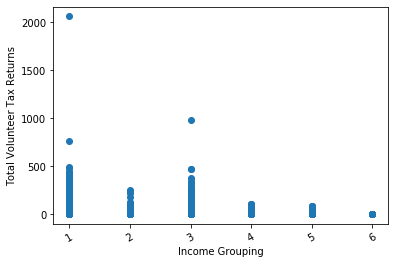

In [31]:
# plot the volunteer tax returns against the income grouping
plt.scatter(df.income_grouping,df.volunteer_returns)
plt.xticks(rotation=30)
plt.xlabel('Income Grouping')
plt.ylabel('Total Volunteer Tax Returns')

In [32]:
# calculate the Pearson's Correlation Coefficient of income grouping and the number of volunteer returns
thinkstats2.Corr(df.income_grouping,df.volunteer_returns)

-0.3325779036958608

In [33]:
# calculate the Spearman's Rank Correlation Coefficient of income grouping and the number of volunteer returns
thinkstats2.SpearmanCorr(df.income_grouping,df.volunteer_returns)

-0.49160990816053735

Text(0, 0.5, 'Total Volunteer Tax Returns')

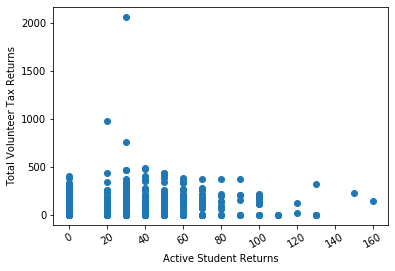

In [34]:
# plot the volunteer tax returns against the number of student returns
plt.scatter(df.active_student_returns,df.volunteer_returns)
plt.xticks(rotation=30)
plt.xlabel('Active Student Returns')
plt.ylabel('Total Volunteer Tax Returns')

In [35]:
# calculate the Pearson's Correlation Coefficient o# calculate the Spearman's Rank Correlation 
# Coefficient of income grouping and the number of volunteer returns

thinkstats2.Corr(df.active_student_returns,df.volunteer_returns)

0.38839619326955827

In [36]:
# calculate the Spearman's Rank Correlation Coefficient o# calculate the Spearman's Rank Correlation Coefficient of income grouping and the number of 
# volunteer returns

thinkstats2.SpearmanCorr(df.active_student_returns,df.volunteer_returns)

0.4444773276284272

In [37]:
# copy in the Diff Means function from the think stats 2 code

class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [38]:
# create sample data out of the under 100k and over 100k data sets

sample_under_len = int(50)
sample_over_len = int(50)
sample_over = thinkstats2.SampleRows(df.income_grouping, sample_over_len)
sample_over_data = sample_over.values
sample_under = thinkstats2.SampleRows(df.volunteer_returns, sample_under_len)
sample_under_data = sample_under.values

data = sample_over_data, sample_under_data

In [45]:
# Calculate the p-value of the diff means test to determine if it is statistically significant

ht = DiffMeansPermute(data)
pvalue = ht.PValue()
pvalue

0.018

In [54]:
# run a regression model between income grouping and the number of volunteer tax returns

formula = 'income_grouping ~ volunteer_returns'
model = smf.ols(formula, data =df)
results = model.fit()
print('The R^2 is {} and the p-value is {}'.format(round(results.rsquared,2),round(results.f_pvalue,4)))

The R^2 is 0.11 and the p-value is 0.0


In [55]:
# run a multiple regression model between income grouping, student returns and the number of volunteer tax returns

model = smf.ols('income_grouping ~ volunteer_returns + active_student_returns', data = df)
resultsm = model.fit()
print('The R^2 is {} and the p-value is {}'.format(round(resultsm.rsquared,2),round(resultsm.f_pvalue,4)))

The R^2 is 0.11 and the p-value is 0.0
